Time series classification: General Transfer Learning with Convolutional Neural Networks

I have performed some time series classification (TSC) experiments applying the standard transfer learning approach we have learned in this course with the idea that it wouldn’t be very useful when applied to time series.

However, the results are great: 93.3% accuracy (very close to the state of the art which is 96.7%).

I think this demonstrates that the fastai transfer learning approach is pretty powerful, and may be applied to lots of different domains, beyond the type of images included in Imagenet.

The goal of the experiment is to identify the country of origin of 30 samples of olive oil based on spectrographs (univariate time series).

The experiment combines 2 approaches that have not been widely used in the TSC domain yet:
- Time series encoding as images. I have tested several approaches, and the one that works better is one where time series are mapped to an image by means of a polar coordinate transformation called the Gramian Angular Field (GAF). This creates a rich graphical representation of a univariate time series. If you are interested you can read this paper 177 (Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks). Based on this the univariate time series, it is transformed into the image.
![png](/images/TSC/1880574621e272cc388a8b03e0e3d733e76d3646.png)
![png](/images/TSC/bc8ac8babe55aa2ab180b7479e85f8fe2cb8980c.png)

- Transfer learning with resnet 50. This is a difficult test as the model has not been previously trained on time series images.

I have used a small UCR time series dataset 68 (Olive oil, with 30 train and 30 test samples) to confirm really test transfer learning. Goal: distinguish extra virgin olive oils from different producing countries

No transformations have been used.

I now plan to apply this same approach to other difficult time series classification problems to get more insight into this technique. Also to modify the standard approach using some transformations which might be useful.



### Import libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from fastai import *
from fastai.vision import *

In [4]:
from pyts.image import *

### Prepare original time series data

You need to download data from http://www.timeseriesclassification.com/Downloads/OliveOil.zip

In [8]:
train_file = Path('~/course-v3/nbs/dl1/my_data/Olive_oil/OliveOil_TRAIN.txt')
test_file = Path('~/course-v3/nbs/dl1/my_data/Olive_oil/OliveOil_TEST.txt')
print(train_file)
print(test_file)

~\course-v3\nbs\dl1\my_data\Olive_oil\OliveOil_TRAIN.txt
~\course-v3\nbs\dl1\my_data\Olive_oil\OliveOil_TEST.txt


In [25]:
train_file = Path('./OliveOil_TRAIN.txt')
test_file = Path('./OliveOil_TEST.txt')
print(train_file)
print(test_file)

OliveOil_TRAIN.txt
OliveOil_TEST.txt


In [27]:
# Train data
raw = open(train_file).readlines()
raw = [map(float, each.strip().split()) for each in raw]
df_data = list()
for i in range(len(raw)):
    df_data.append(list(raw[i]))
train_df = pd.DataFrame(df_data)
train_df

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.0,-0.611375,-0.610586,-0.606557,-0.601132,-0.594315,-0.585762,-0.577419,-0.570175,-0.563285,...,-0.979553,-0.980385,-0.980328,-0.980220,-0.980691,-0.981337,-0.982336,-0.983213,-0.983672,-0.983120
1,1.0,-0.615392,-0.613729,-0.609228,-0.604315,-0.598768,-0.590507,-0.581617,-0.572926,-0.565374,...,-0.979210,-0.979335,-0.979523,-0.980038,-0.981146,-0.982332,-0.982570,-0.982630,-0.982850,-0.982549
2,1.0,-0.611999,-0.610500,-0.606374,-0.600445,-0.593084,-0.585245,-0.577118,-0.568827,-0.561596,...,-0.979514,-0.979663,-0.979964,-0.980563,-0.981326,-0.982744,-0.983107,-0.983033,-0.983956,-0.983858
3,1.0,-0.622784,-0.622222,-0.619049,-0.613251,-0.605889,-0.597508,-0.589047,-0.580697,-0.572822,...,-0.968819,-0.969902,-0.970586,-0.970718,-0.971197,-0.972268,-0.972654,-0.972861,-0.973671,-0.973614
4,1.0,-0.621793,-0.621272,-0.617298,-0.612074,-0.605472,-0.597607,-0.589165,-0.581424,-0.574620,...,-0.977420,-0.977831,-0.978376,-0.978778,-0.979656,-0.981148,-0.981796,-0.981331,-0.981289,-0.981331
5,2.0,-0.600229,-0.599577,-0.596144,-0.590664,-0.583358,-0.574398,-0.565483,-0.557200,-0.549211,...,-0.986319,-0.987329,-0.987618,-0.988062,-0.988807,-0.989265,-0.989560,-0.989695,-0.990430,-0.990874
6,2.0,-0.615430,-0.614164,-0.610041,-0.603962,-0.596794,-0.588885,-0.579624,-0.571410,-0.564899,...,-0.978359,-0.978609,-0.979123,-0.979192,-0.979726,-0.980732,-0.980855,-0.981049,-0.982046,-0.982640
7,2.0,-0.614015,-0.612369,-0.608472,-0.602971,-0.596025,-0.588022,-0.579095,-0.570355,-0.562975,...,-0.977127,-0.977156,-0.977082,-0.978072,-0.978743,-0.979156,-0.980033,-0.980179,-0.980446,-0.981325
8,2.0,-0.596650,-0.595023,-0.591794,-0.586665,-0.579232,-0.571202,-0.562909,-0.554685,-0.547703,...,-0.986295,-0.986149,-0.986728,-0.987620,-0.988761,-0.989280,-0.989334,-0.989841,-0.990268,-0.990883
9,2.0,-0.620747,-0.620111,-0.616434,-0.611036,-0.603726,-0.595674,-0.587556,-0.579830,-0.573194,...,-0.975419,-0.975879,-0.976500,-0.977168,-0.977320,-0.977985,-0.978558,-0.978633,-0.978808,-0.979470


In [28]:
# Train data
raw = open(test_file).readlines()
raw = [map(float, each.strip().split()) for each in raw]
df_data = list()
for i in range(len(raw)):
    df_data.append(list(raw[i]))
test_df = pd.DataFrame(df_data)
test_df

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.0,-0.621957,-0.620677,-0.616684,-0.611012,-0.603769,-0.595267,-0.586477,-0.577899,-0.570147,...,-0.966336,-0.967106,-0.967484,-0.967454,-0.967817,-0.968638,-0.969142,-0.969541,-0.970344,-0.970377
1,1.0,-0.618925,-0.618361,-0.614664,-0.608693,-0.601446,-0.593516,-0.585786,-0.577708,-0.569952,...,-0.971519,-0.971990,-0.972353,-0.973022,-0.973667,-0.973943,-0.974423,-0.974906,-0.975525,-0.975858
2,1.0,-0.618169,-0.616704,-0.612678,-0.607578,-0.600574,-0.592209,-0.584307,-0.576085,-0.567684,...,-0.976493,-0.976940,-0.977284,-0.977284,-0.977531,-0.978806,-0.979570,-0.979820,-0.980319,-0.980089
3,1.0,-0.613445,-0.611719,-0.607739,-0.602477,-0.595154,-0.587271,-0.579135,-0.570903,-0.563252,...,-0.976533,-0.977072,-0.977317,-0.977812,-0.978423,-0.979332,-0.979976,-0.980131,-0.980358,-0.980385
4,1.0,-0.616338,-0.615301,-0.611505,-0.605503,-0.597522,-0.589108,-0.580610,-0.572432,-0.565709,...,-0.974940,-0.975242,-0.975344,-0.975936,-0.976761,-0.977364,-0.977648,-0.978043,-0.978808,-0.978584
5,2.0,-0.618782,-0.617716,-0.613997,-0.608234,-0.601079,-0.593254,-0.585160,-0.577374,-0.569800,...,-0.974467,-0.974664,-0.974808,-0.975386,-0.975538,-0.976176,-0.977076,-0.977115,-0.977705,-0.978321
6,2.0,-0.618084,-0.615795,-0.611206,-0.605597,-0.598689,-0.591469,-0.583601,-0.574438,-0.567063,...,-0.974884,-0.975553,-0.975290,-0.975443,-0.976166,-0.977054,-0.977661,-0.977825,-0.977879,-0.978005
7,2.0,-0.611166,-0.610133,-0.606317,-0.600795,-0.593912,-0.585110,-0.576604,-0.569136,-0.562062,...,-0.981540,-0.981895,-0.982864,-0.983285,-0.983986,-0.985206,-0.985308,-0.985060,-0.985320,-0.986107
8,2.0,-0.611302,-0.610611,-0.607795,-0.601815,-0.594525,-0.586312,-0.577069,-0.568377,-0.561396,...,-0.977748,-0.978070,-0.978492,-0.979135,-0.980142,-0.981493,-0.982160,-0.981877,-0.981701,-0.982029
9,2.0,-0.622387,-0.621123,-0.617521,-0.612813,-0.606186,-0.598040,-0.590471,-0.582751,-0.574777,...,-0.977619,-0.978230,-0.978459,-0.978754,-0.979418,-0.980146,-0.980762,-0.981045,-0.981799,-0.982103


In [16]:
train_df = pd.read_csv(train_file, sep=';', header=None)
#display(train_df.head())
# remove all columns which are completely empty
train_df.dropna(axis=1, how='all', inplace=True)
# fill all missing columns with 0
train_df.fillna(0, inplace=True)
y_train = train_df[[0]].values
nb_classes = len(np.unique(y_train))
y_train = ((y_train - y_train.min()) / (y_train.max() - y_train.min()) * (nb_classes - 1)).astype(int)
# drop labels column from train set X
train_df.drop(train_df.columns[0], axis=1, inplace=True)
X_train = train_df.values
X_train = X_train[:, np.newaxis, :]
# scale the values
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / (X_train_std + 1e-8)
X_train = np.squeeze(X_train)
y_train = y_train.ravel()
print(X_train.shape, X_train[0].shape)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [17]:
test_df = pd.read_csv(test_file, sep=';', header=None)
#display(test_df.head())
# remove all columns which are completely empty
test_df.dropna(axis=1, how='all', inplace=True)
# fill all missing columns with 0
test_df.fillna(0, inplace=True)
y_test = test_df[[0]].values
nb_classes_test = len(np.unique(y_test))
y_test = ((y_test - y_test.min()) / (y_test.max() - y_test.min()) * (nb_classes_test - 1)).astype(int)
# drop labels column from test set X
test_df.drop(test_df.columns[0], axis=1, inplace=True)
X_test = test_df.values
# scale the values
X_test = X_test[:, np.newaxis, :]
# scale the values
X_test = (X_test - X_train_mean) / (X_train_std + 1e-8)
X_test = np.squeeze(X_test)
y_test = y_test.ravel()
print(X_test.shape, X_test[0].shape)

TypeError: unsupported operand type(s) for -: 'str' and 'str'

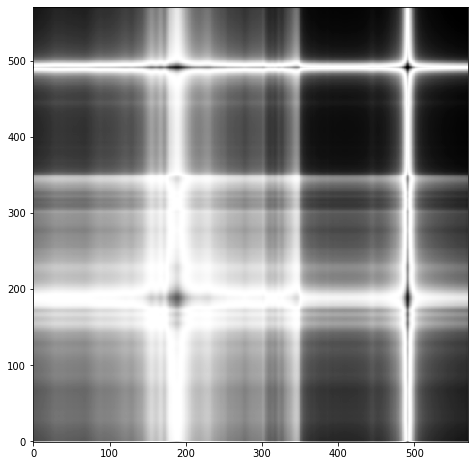

In [37]:
from pyts.datasets import load_gunpoint
from pyts.image import GramianAngularField
X=train_df
transformer = GramianAngularField()
X_new = transformer.transform(X)
X_new.shape

# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(X_new[0], cmap='binary', origin='lower')
plt.show()

In [40]:
from pyts.datasets import load_gunpoint
bunch = load_gunpoint()
bunch.data_train.shape
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)
X_train.shape

(50, 150)

In [44]:
y_train

array([2, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2,
       2, 2, 2, 2, 1, 1, 1, 2, 2, 1, 2, 1, 2], dtype=int64)

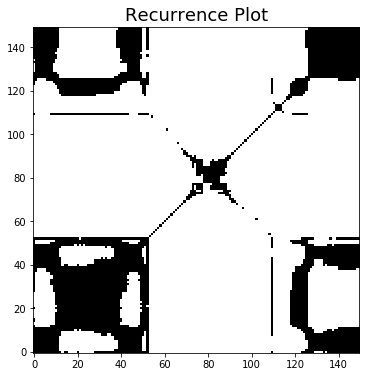

In [45]:
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlot
from pyts.datasets import load_gunpoint

X, _, _, _ = load_gunpoint(return_X_y=True)

# Recurrence plot transformation
rp = RecurrencePlot(threshold='point', percentage=20)
X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(6, 6))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.title('Recurrence Plot', fontsize=18)
plt.show()

In [47]:
X.shape

(50, 150)

In [29]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,561,562,563,564,565,566,567,568,569,570
0,1.0,-0.611375,-0.610586,-0.606557,-0.601132,-0.594315,-0.585762,-0.577419,-0.570175,-0.563285,...,-0.979553,-0.980385,-0.980328,-0.980220,-0.980691,-0.981337,-0.982336,-0.983213,-0.983672,-0.983120
1,1.0,-0.615392,-0.613729,-0.609228,-0.604315,-0.598768,-0.590507,-0.581617,-0.572926,-0.565374,...,-0.979210,-0.979335,-0.979523,-0.980038,-0.981146,-0.982332,-0.982570,-0.982630,-0.982850,-0.982549
2,1.0,-0.611999,-0.610500,-0.606374,-0.600445,-0.593084,-0.585245,-0.577118,-0.568827,-0.561596,...,-0.979514,-0.979663,-0.979964,-0.980563,-0.981326,-0.982744,-0.983107,-0.983033,-0.983956,-0.983858
3,1.0,-0.622784,-0.622222,-0.619049,-0.613251,-0.605889,-0.597508,-0.589047,-0.580697,-0.572822,...,-0.968819,-0.969902,-0.970586,-0.970718,-0.971197,-0.972268,-0.972654,-0.972861,-0.973671,-0.973614
4,1.0,-0.621793,-0.621272,-0.617298,-0.612074,-0.605472,-0.597607,-0.589165,-0.581424,-0.574620,...,-0.977420,-0.977831,-0.978376,-0.978778,-0.979656,-0.981148,-0.981796,-0.981331,-0.981289,-0.981331
5,2.0,-0.600229,-0.599577,-0.596144,-0.590664,-0.583358,-0.574398,-0.565483,-0.557200,-0.549211,...,-0.986319,-0.987329,-0.987618,-0.988062,-0.988807,-0.989265,-0.989560,-0.989695,-0.990430,-0.990874
6,2.0,-0.615430,-0.614164,-0.610041,-0.603962,-0.596794,-0.588885,-0.579624,-0.571410,-0.564899,...,-0.978359,-0.978609,-0.979123,-0.979192,-0.979726,-0.980732,-0.980855,-0.981049,-0.982046,-0.982640
7,2.0,-0.614015,-0.612369,-0.608472,-0.602971,-0.596025,-0.588022,-0.579095,-0.570355,-0.562975,...,-0.977127,-0.977156,-0.977082,-0.978072,-0.978743,-0.979156,-0.980033,-0.980179,-0.980446,-0.981325
8,2.0,-0.596650,-0.595023,-0.591794,-0.586665,-0.579232,-0.571202,-0.562909,-0.554685,-0.547703,...,-0.986295,-0.986149,-0.986728,-0.987620,-0.988761,-0.989280,-0.989334,-0.989841,-0.990268,-0.990883
9,2.0,-0.620747,-0.620111,-0.616434,-0.611036,-0.603726,-0.595674,-0.587556,-0.579830,-0.573194,...,-0.975419,-0.975879,-0.976500,-0.977168,-0.977320,-0.977985,-0.978558,-0.978633,-0.978808,-0.979470


In [19]:
#train_df = pd.read_csv(train_file, sep=';', header=None)
#display(train_df.head())
# remove all columns which are completely empty
train_df.dropna(axis=1, how='all', inplace=True)
# fill all missing columns with 0
train_df.fillna(0, inplace=True)
y_train = train_df[[0]].values
nb_classes = len(np.unique(y_train))
# y_train = ((y_train - y_train.min()) / (y_train.max() - y_train.min()) * (nb_classes - 1)).astype(int)
# drop labels column from train set X
train_df.drop(train_df.columns[0], axis=1, inplace=True)
X_train = train_df.values
X_train = X_train[:, np.newaxis, :]
# scale the values
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / (X_train_std + 1e-8)
X_train = np.squeeze(X_train)
y_train = y_train.ravel()
print(X_train.shape, X_train[0].shape)

(614, 0) (0,)


In [122]:
print("Number of train samples : ", X_train.shape[0], "Number of test samples : ", X_test.shape[0])
print("Number of classes : ", nb_classes, sorted(np.unique(y_train)))
print("Sequence length : ", X_train.shape[-1])

Number of train samples :  30 Number of test samples :  30
Number of classes :  4 [0, 1, 2, 3]
Sequence length :  570


### Visualize time series data & data transformation

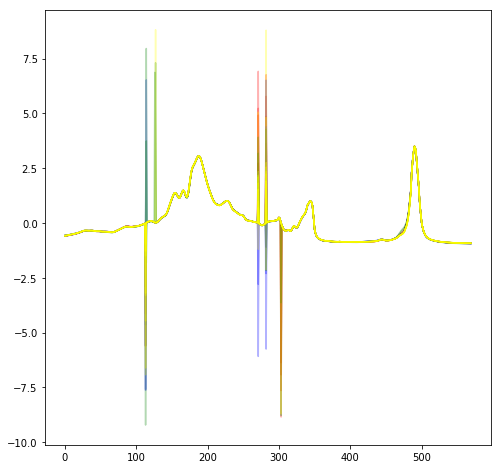

In [9]:
plt.figure(figsize=(8, 8))
colors = ['red', 'blue', 'green', 'yellow']
for i in range(len(X_train)):
    plt.plot(X_train[i], color=colors[y_train[i]], alpha=.3)
plt.show()

In [22]:
from pyts.image import RecurrencePlots

ImportError: cannot import name 'RecurrencePlots' from 'pyts.image' (C:\ProgramData\Anaconda3\lib\site-packages\pyts\image\__init__.py)

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pyts.image import RecurrencePlots

# Parameters
n_samples, n_features = 100, 144

# Toy dataset
rng = np.random.RandomState(41)
X = rng.randn(n_samples, n_features)

# Recurrence plot transformation
rp = RecurrencePlots(dimension=1,
                     epsilon='percentage_points',
                     percentage=30)
X_rp = rp.fit_transform(X)

# Show the results for the first time series
plt.figure(figsize=(8, 8))
plt.imshow(X_rp[0], cmap='binary', origin='lower')
plt.show()

ImportError: cannot import name 'RecurrencePlots' from 'pyts.image' (C:\ProgramData\Anaconda3\lib\site-packages\pyts\image\__init__.py)

In [20]:
from pyts.image import GASF, GADF, MTF, RecurrencePlots

# Image transformations
image_size = 570
gasf = GASF(image_size)
X_gasf = gasf.fit_transform(X_train)
gadf = GADF(image_size)
X_gadf = gadf.fit_transform(X_train)
mtf = MTF(64)
X_mtf = mtf.fit_transform(X_train)
rp = RecurrencePlots(dimension=1,
                     epsilon=None,
                     percentage=10)
X_rp = rp.fit_transform(X_train)
                        
sel_image = np.random.randint(len(X_train))
print('Selected image:', sel_image, 'class:', y_train[sel_image])

# Show the results for the first time series
print(X_train[sel_image].shape)
plt.figure(figsize=(8, 8))
plt.plot(X_train[sel_image])
plt.show()

print(X_gasf[sel_image].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_gasf[sel_image], cmap='rainbow', origin='lower')
plt.title('GASF', fontsize=16)
plt.show()

print(X_gadf[sel_image].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_gadf[sel_image], cmap='viridis', origin='lower')
plt.title('GADF', fontsize=16)
plt.show()

print(X_mtf[sel_image].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_mtf[sel_image], cmap='magma', origin='lower')
plt.title('MTF', fontsize=16)
plt.show()


print(X_rp[sel_image].shape)
plt.figure(figsize=(8, 8))
plt.imshow(X_rp[sel_image], cmap='viridis', origin='lower')
plt.title('RP', fontsize=16)
plt.show()

ImportError: cannot import name 'GASF' from 'pyts.image' (C:\ProgramData\Anaconda3\lib\site-packages\pyts\image\__init__.py)

### Time series data augmentation: Noised_ts fn

In [123]:
def noised_ts(ots, noise_mult=.01, noise_type='add'):
    # noise_type = 'add', 'mult'
    if noise_type not in [None, 'add', 'mult']:
        raise AttributeError ('Incorrect noise_type')
    if noise_mult == 0 or not noise_type:
        return ots
    print('noise_ts activated:', noise_mult)
    if ots.ndim == 1: 
        ts = np.array([ots])
    else:
        ts = copy(ots)
    ns_ts = copy(ts)
    for i in range(len(ts)):
        diff = pd.Series(ts[i]).diff()
        if noise_type == 'add':
            noise = np.random.normal(0, np.std(diff) * noise_mult, len(diff))
            ns_ts[i] = ts[i] + noise
        elif noise_type == 'mult':
            noise = np.random.normal(1, np.std(diff) * noise_mult, len(diff))
            ns_ts[i] = ts[i] * noise
    if ots.ndim == 1: 
        return ns_ts[0]
    else:
        return ns_ts

### Generate images

In [124]:
IMG_PATH = Path('my_data/Olive_oil')
image_size = 570

In [125]:
img_algo = 'GADF' # GASF, GADF, MTF, RP
directory = 'TRAIN' # TRAIN, TEST
noise_type = 'add' # None, add, mult
noise_mult = 0.1

In [131]:
from pyts.image import GASF, GADF, MTF, RecurrencePlots

if img_algo == 'GASF':
    transf = GASF(image_size)
    X_gasf = transf.fit_transform(
        noised_ts(X_train, noise_mult=noise_mult, noise_type=noise_type))
    cmap = 'rainbow'
elif img_algo == 'GADF':
    transf = GADF(image_size)
    X_gadf = transf.fit_transform(
        noised_ts(X_train, noise_mult=noise_mult, noise_type=noise_type))
    cmap = 'viridis'
elif img_algo == 'MTF':
    transf = MTF(64)
    X_mtf = transf.fit_transform(
        noised_ts(X_train, noise_mult=noise_mult, noise_type=noise_type))
    cmap = 'magma'
elif img_algo == 'RP':
    transf = RecurrencePlots(dimension=1, epsilon=None, percentage=10)
    X_rp = transf.fit_transform(
        noised_ts(X_train, noise_mult=noise_mult, noise_type=noise_type))
    cmap = 'binary'
    

if directory == 'TRAIN':
    x_samples = X_train
    y_samples = y_train
elif directory == 'TEST':
    x_samples = X_test
    y_samples = y_test
folder = IMG_PATH/img_algo/directory


for i in range(len(y_samples)):
    img_id = img_algo + '_' + str(i) + '_' + str(image_size)+ '.png'
    if noise_type:
        img_id = 'N_' + img_id
    class_dir = str(y_samples[i])
    class_folder = folder/class_dir
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)
    img_dir = class_folder/img_id
    plt.figure(figsize=(8, 8))
    plt.imshow(transf.transform(x_samples[i]), cmap=cmap, origin='lower')
    plt.title(img_algo, fontsize=16)
    plt.savefig(img_dir, transparent=True)
    plt.close()
    
print('ok')

noise_ts activated: 0.1


ValueError: Expected 2D array, got 1D array instead:
array=[-0.578058 -0.577312 -0.573508 -0.568386 ... -0.92835  -0.929177 -0.929611 -0.929089].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

<Figure size 576x576 with 0 Axes>

### Create dataset

In [36]:
IMG_PATH = Path('my_data/Olive_oil')
image_size = 570
img_algo = 'GADF' # GASF, GADF, MTF, RP
bs = 16

In [37]:
np.random.seed(42)
data = ImageDataBunch.from_folder(IMG_PATH/img_algo, train="TRAIN", valid='TEST',
        ds_tfms=None, size=image_size, num_workers=4, bs=bs).normalize(imagenet_stats)

In [38]:
data.classes, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2', '3'], 60, 30)

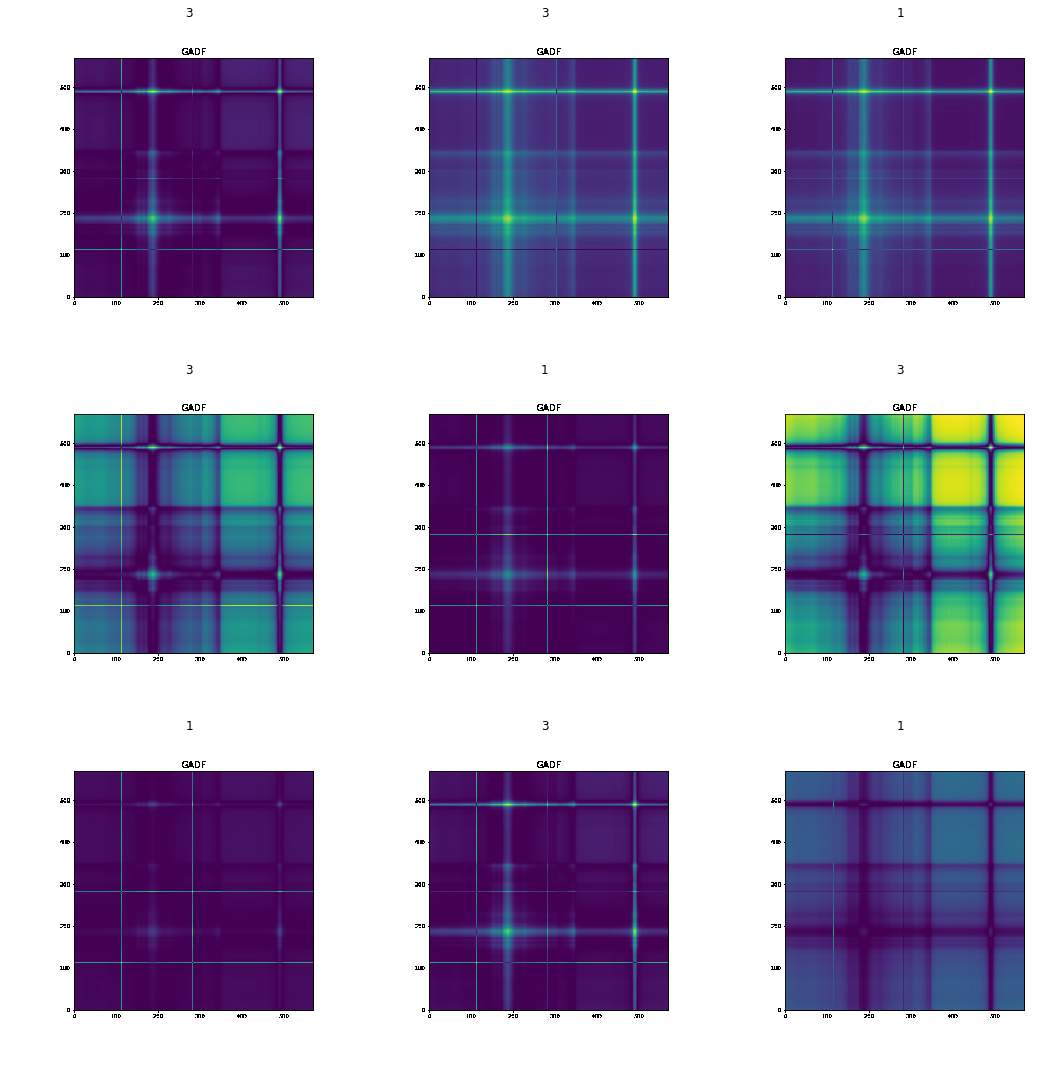

In [39]:
data.show_batch(rows=3, figsize=(15,15))

In [165]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['0', '1', '2', '3'], 4, 30, 30)

### MTF: train model

In [77]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.save('stage0')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


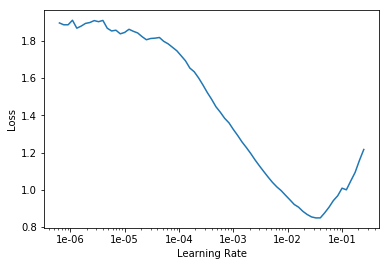

In [78]:
learn.lr_find()
learn.recorder.plot()

In [79]:
# resnet50
learn.load('stage0c')
learn.fit_one_cycle(20)

Total time: 00:22
epoch  train_loss  valid_loss  error_rate
1      1.910907    1.534212    0.700000    (00:01)
2      1.447413    1.618028    0.700000    (00:01)
3      1.189886    1.650232    0.700000    (00:01)
4      1.002296    1.647247    0.666667    (00:01)
5      0.836151    1.646056    0.633333    (00:01)
6      0.714241    1.486731    0.600000    (00:01)
7      0.617629    1.105498    0.366667    (00:01)
8      0.541159    0.764967    0.200000    (00:01)
9      0.480990    0.595498    0.233333    (00:01)
10     0.430742    0.522783    0.200000    (00:01)
11     0.412972    0.449888    0.100000    (00:01)
12     0.375366    0.402491    0.066667    (00:01)
13     0.353849    0.370563    0.066667    (00:01)
14     0.323675    0.356308    0.066667    (00:01)
15     0.298308    0.364744    0.066667    (00:01)
16     0.281457    0.375562    0.066667    (00:01)
17     0.261504    0.384074    0.066667    (00:01)
18     0.243063    0.388952    0.066667    (00:01)
19     0.228112    0.3

(None, None)

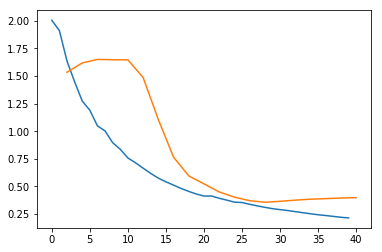

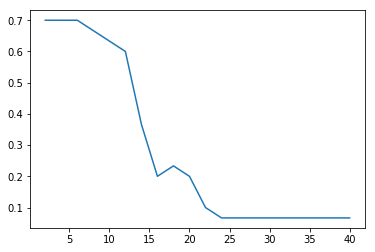

In [81]:
learn.save('stage1c')
learn.load('stage1c')
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

In [82]:
learn.load('stage1c')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


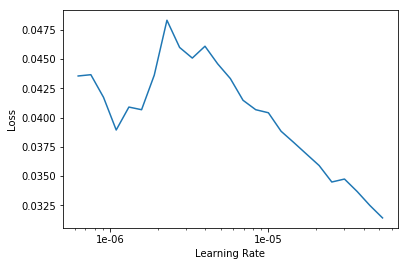

In [83]:
learn.lr_find()
learn.recorder.plot()

In [86]:
learn.load('stage1c')
learn.fit_one_cycle(3, 1e-7)

Total time: 00:03
epoch  train_loss  valid_loss  error_rate
1      0.242926    0.403719    0.066667    (00:01)
2      0.136670    0.408909    0.066667    (00:01)
3      0.110443    0.413616    0.066667    (00:01)



### GASF: train model

In [19]:
learn = create_cnn(data, models.resnet50, metrics=error_rate)
learn.save('stage0')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


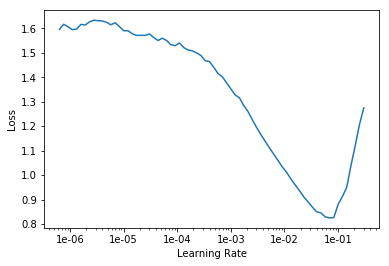

In [17]:
learn.lr_find()
learn.recorder.plot()

In [20]:
# resnet50
learn.load('stage0')
learn.fit_one_cycle(20)

Total time: 00:33
epoch  train_loss  valid_loss  error_rate
1      1.675378    1.650934    0.718750    (00:07)
2      1.473338    1.546432    0.718750    (00:01)
3      1.195509    1.512178    0.718750    (00:01)
4      0.973597    1.436057    0.687500    (00:01)
5      0.831292    1.260836    0.500000    (00:01)
6      0.711482    1.114111    0.500000    (00:01)
7      0.617269    0.948917    0.406250    (00:01)
8      0.554168    0.758529    0.312500    (00:01)
9      0.487647    0.633840    0.281250    (00:01)
10     0.437264    0.525563    0.218750    (00:01)
11     0.392850    0.445310    0.125000    (00:01)
12     0.356042    0.378479    0.062500    (00:01)
13     0.328884    0.336836    0.062500    (00:01)
14     0.301286    0.319211    0.062500    (00:01)
15     0.277188    0.308177    0.062500    (00:01)
16     0.254901    0.310053    0.062500    (00:01)
17     0.239773    0.317117    0.062500    (00:01)
18     0.223749    0.324538    0.062500    (00:01)
19     0.209604    0.3

(None, None)

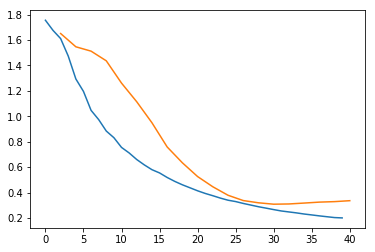

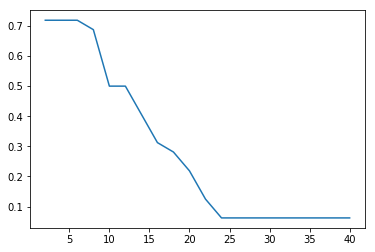

In [21]:
learn.save('stage1')
learn.load('stage1')
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

In [22]:
learn.load('stage1')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


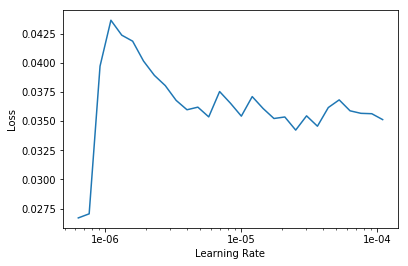

In [23]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.load('stage0')
learn.fit_one_cycle(20)

### GAFD: train model

#### Instantiate model

In [8]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [9]:
learn.save('stage0_GAFD')

#### LR finder

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


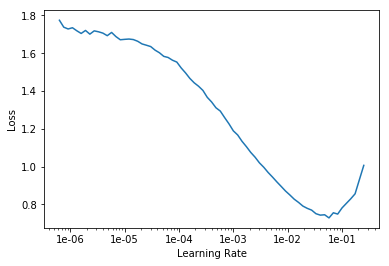

In [10]:
learn.lr_find()
learn.recorder.plot()

#### Train stage 1

In [11]:
# Add callbacks after LR finder because otherwise it breaks
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.load('stage0_GAFD')

In [12]:
learn.fit_one_cycle(10)

Total time: 00:36
epoch  train_loss  valid_loss  accuracy
1      2.072426    1.724388    0.133333  (00:07)
2      1.526831    1.631479    0.166667  (00:03)
3      1.146460    1.549957    0.200000  (00:03)
4      0.927078    1.464315    0.333333  (00:03)
5      0.775944    1.235155    0.533333  (00:03)
6      0.659643    0.961604    0.600000  (00:03)
7      0.566333    0.814346    0.600000  (00:03)
8      0.499693    0.690065    0.700000  (00:03)
9      0.443075    0.628020    0.700000  (00:03)
10     0.396482    0.536980    0.866667  (00:03)



In [13]:
learn.save('stage1_GAFD')

In [14]:
learn.load('stage1_GAFD')

(None, None)

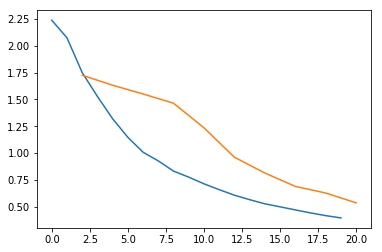

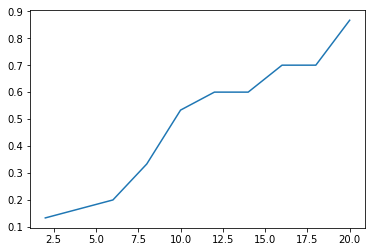

In [15]:
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

#### Unfreeze & train stage 2

In [16]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('stage1_GAFD')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


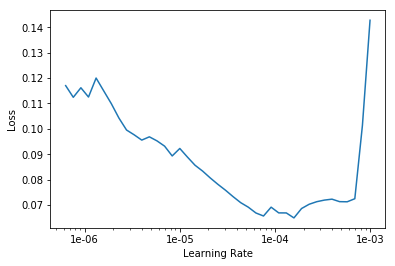

In [19]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.unfreeze()
learn.load('stage1_GAFD')
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))

Total time: 00:32
epoch  train_loss  valid_loss  accuracy
1      0.044338    0.441741    0.900000  (00:02)
2      0.076127    0.354277    0.933333  (00:03)
3      0.072997    0.300887    0.933333  (00:03)
4      0.072353    0.265292    0.933333  (00:03)
5      0.098103    0.249091    0.933333  (00:03)
6      0.090606    0.237940    0.933333  (00:03)
7      0.081822    0.230483    0.933333  (00:03)
8      0.075960    0.225896    0.933333  (00:03)
9      0.069940    0.227627    0.933333  (00:03)
10     0.067386    0.227189    0.933333  (00:02)



In [22]:
learn.save('stage2_GAFD')

(None, None)

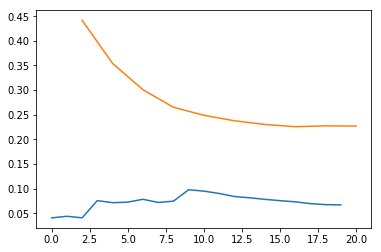

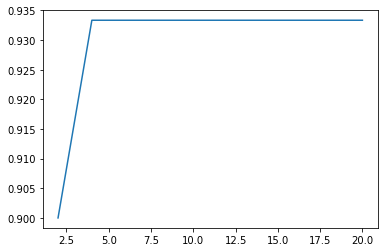

In [23]:
learn.load('stage2_GAFD')
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

### GAFD: train model (augmented)

#### Instantiate model

In [87]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [88]:
learn.save('stage0_GAFD_aug')

#### LR finder

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


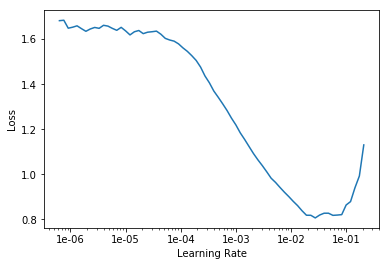

In [47]:
learn.lr_find()
learn.recorder.plot()

#### Train stage 1

In [84]:
# Add callbacks after LR finder because otherwise it breaks
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.load('stage0_GAFD_aug')

In [51]:
learn.fit_one_cycle(20)

Total time: 01:11
epoch  train_loss  valid_loss  accuracy
1      1.548100    1.348880    0.333333  (00:03)
2      1.125783    1.439569    0.300000  (00:04)
3      0.831134    1.305803    0.466667  (00:03)
4      0.691063    0.893060    0.600000  (00:03)
5      0.573205    0.555537    0.833333  (00:03)
6      0.475245    0.443912    0.900000  (00:03)
7      0.407698    0.363964    0.933333  (00:03)
8      0.351789    0.263092    0.933333  (00:03)
9      0.306857    0.313972    0.933333  (00:03)
10     0.281621    0.316096    0.933333  (00:03)
11     0.268640    0.229095    0.933333  (00:03)
12     0.259773    0.341707    0.933333  (00:03)
13     0.237674    0.424936    0.933333  (00:03)
14     0.212778    0.430942    0.933333  (00:03)
15     0.192006    0.431438    0.933333  (00:03)
16     0.180131    0.439620    0.933333  (00:03)
17     0.165849    0.440619    0.933333  (00:03)
18     0.150561    0.439981    0.933333  (00:03)
19     0.137825    0.444497    0.933333  (00:03)
20     0.12

In [52]:
learn.save('stage1_GAFD_aug')

In [53]:
learn.load('stage1_GAFD_aug')

(None, None)

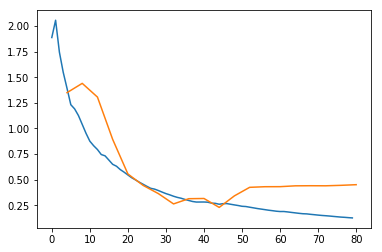

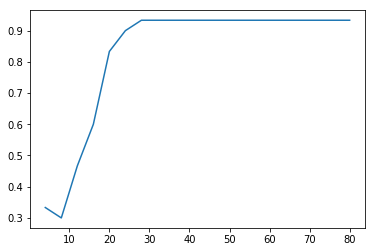

In [54]:
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

In [89]:
learn.fit_one_cycle(2)

Total time: 00:06
epoch  train_loss  valid_loss  accuracy
1      1.752475    1.569479    0.166667  (00:03)
2      1.117291    1.488003    0.266667  (00:03)



In [91]:
learn.save('stage1_GAFD_aug_2')

#### Unfreeze & train stage 2

In [55]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('stage1_GAFD_aug')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


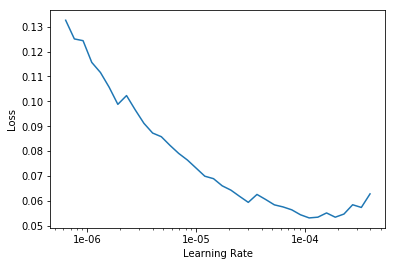

In [57]:
learn.lr_find()
learn.recorder.plot()

In [67]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.unfreeze()

In [68]:
learn.load('stage1_GAFD_aug')

In [69]:
learn.fit_one_cycle(10, max_lr=slice(3e-7, 3e-6))

epoch,train_loss,valid_loss,accuracy
1,0.046194,0.225656,0.933333
2,0.053959,0.236318,0.933333
3,0.069406,0.251910,0.933333
4,0.066667,0.271065,0.933333
5,0.066175,0.286278,0.933333
6,0.064859,0.308344,0.933333


KeyboardInterrupt: 

In [22]:
learn.save('stage2_GAFD_aug')

(None, None)

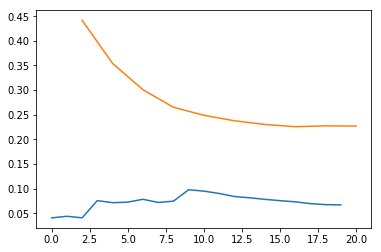

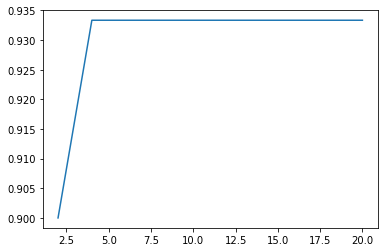

In [23]:
learn.load('stage2_GAFD_aug')
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

In [92]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('stage1_GAFD_aug_2')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


Traceback (most recent call last):
  File "/home/oguiza/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/oguiza/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/oguiza/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/oguiza/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/oguiza/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/oguiza/anaconda3/envs/fastai-v1/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/oguiza/a

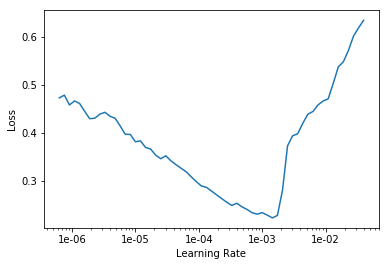

In [93]:
learn.lr_find()
learn.recorder.plot()

In [102]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.unfreeze()

In [103]:
learn.load('stage1_GAFD_aug_2')

In [104]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-3))

Total time: 00:40
epoch  train_loss  valid_loss  accuracy
1      0.355948    1.154909    0.500000  (00:03)
2      0.328680    0.871483    0.566667  (00:04)
3      0.268086    0.621401    0.866667  (00:04)
4      0.208109    0.447577    0.933333  (00:04)
5      0.188518    0.296246    0.933333  (00:04)
6      0.168940    0.214553    0.933333  (00:04)
7      0.149034    0.296013    0.933333  (00:04)
8      0.128838    0.372550    0.933333  (00:03)
9      0.113371    0.402561    0.933333  (00:03)
10     0.099914    0.422125    0.933333  (00:03)



In [105]:
learn.save('stage2_GAFD_aug_2')

In [106]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('stage2_GAFD_aug_2')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


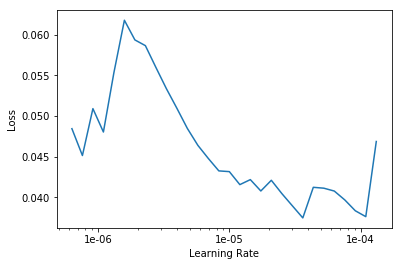

In [107]:
learn.lr_find()
learn.recorder.plot()

In [108]:
learn.fit_one_cycle(10, max_lr=slice(3e-6, 1e-5))

Total time: 00:38
epoch  train_loss  valid_loss  accuracy
1      0.032618    0.221139    0.933333  (00:03)
2      0.025833    0.275642    0.933333  (00:03)
3      0.024725    0.349143    0.933333  (00:03)
4      0.038912    0.405448    0.933333  (00:03)
5      0.035979    0.427796    0.933333  (00:03)
6      0.033702    0.424695    0.933333  (00:03)
7      0.030270    0.423956    0.933333  (00:03)
8      0.027543    0.421023    0.933333  (00:03)
9      0.027178    0.431710    0.933333  (00:03)
10     0.026997    0.432780    0.933333  (00:03)



### RP: train model

#### Instantiate model

In [9]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [10]:
learn.save('stage0_RP')

#### LR finder

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


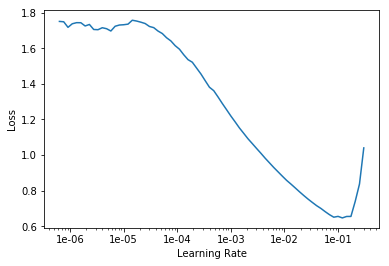

In [11]:
learn.lr_find()
learn.recorder.plot()

#### Train stage 1

In [13]:
# Add callbacks after LR finder because otherwise it breaks
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.load('stage0_RP')

In [14]:
learn.fit_one_cycle(10)

Total time: 00:32
epoch  train_loss  valid_loss  accuracy
1      1.384489    1.511187    0.166667  (00:07)
2      1.254226    1.591642    0.266667  (00:02)
3      1.138441    1.421307    0.233333  (00:02)
4      0.926108    1.597923    0.233333  (00:03)
5      0.768617    1.666555    0.166667  (00:02)
6      0.694969    1.470457    0.300000  (00:02)
7      0.629404    1.310965    0.433333  (00:02)
8      0.549178    1.225477    0.500000  (00:02)
9      0.488721    1.205973    0.466667  (00:03)
10     0.437373    1.148020    0.433333  (00:02)



In [15]:
learn.save('stage1_RP')

In [16]:
learn.load('stage1_RP')

(None, None)

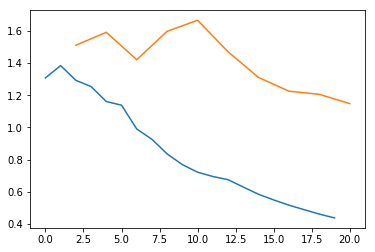

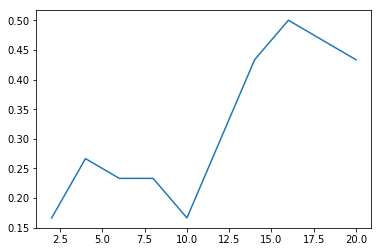

In [17]:
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

#### Unfreeze & train stage 2

In [18]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('stage1_RP')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


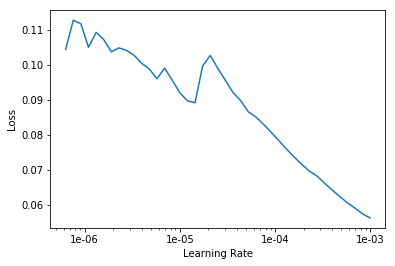

In [19]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.unfreeze()
learn.load('stage1_RP')
learn.fit_one_cycle(20, max_lr=slice(1e-6, 3e-4))

Total time: 01:03
epoch  train_loss  valid_loss  accuracy
1      0.058751    1.119651    0.400000  (00:02)
2      0.091122    1.061235    0.433333  (00:03)
3      0.111314    0.988564    0.466667  (00:03)
4      0.097122    0.964704    0.466667  (00:03)
5      0.088349    0.929800    0.533333  (00:03)
6      0.079939    0.928350    0.566667  (00:03)
7      0.069871    0.889880    0.633333  (00:03)
8      0.062668    0.813839    0.700000  (00:03)
9      0.056809    0.740274    0.800000  (00:03)
10     0.051475    0.701047    0.833333  (00:03)
11     0.066705    0.592973    0.800000  (00:03)
12     0.061093    0.542043    0.800000  (00:03)
13     0.061153    0.480129    0.833333  (00:03)
14     0.057168    0.465673    0.800000  (00:03)
15     0.054588    0.455717    0.800000  (00:03)
16     0.050611    0.443322    0.900000  (00:03)
17     0.054943    0.487368    0.900000  (00:03)
18     0.052073    0.494564    0.866667  (00:02)
19     0.050333    0.498746    0.900000  (00:02)
20     0.04

In [25]:
learn.save('stage2_RP')

(None, None)

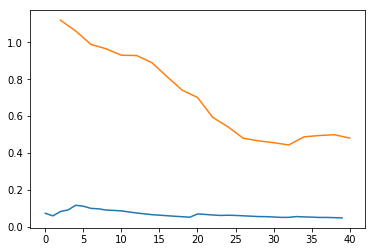

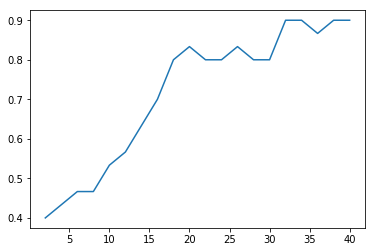

In [26]:
learn.load('stage2_RP')
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

### Interpretation

In [38]:
learn.load('stage2_GAFD')
interp = ClassificationInterpretation.from_learner(learn)

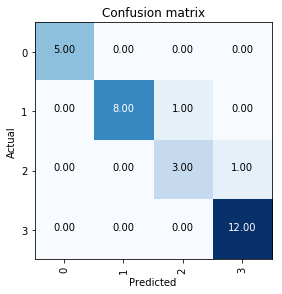

In [39]:
interp.plot_confusion_matrix()

### GAFD: train model

#### Instantiate model

In [86]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [72]:
learn.save('stage0_GAFD')

#### LR finder

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


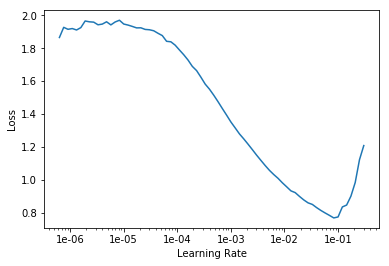

In [73]:
learn.lr_find()
learn.recorder.plot()

#### Train stage 1

In [74]:
# Add callbacks after LR finder because otherwise it breaks
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.load('stage0_GAFD')

In [75]:
learn.fit_one_cycle(10)

Total time: 00:29
epoch  train_loss  valid_loss  accuracy
1      1.988337    1.412030    0.300000  (00:02)
2      1.555344    1.330894    0.400000  (00:03)
3      1.142555    1.470983    0.266667  (00:03)
4      0.911886    1.499328    0.300000  (00:02)
5      0.743997    1.341348    0.333333  (00:02)
6      0.649579    1.097123    0.366667  (00:02)
7      0.554331    0.882397    0.466667  (00:03)
8      0.486237    0.696902    0.700000  (00:03)
9      0.433088    0.521921    0.933333  (00:03)
10     0.389934    0.426546    0.933333  (00:03)



In [76]:
learn.save('stage1_GAFD')

In [77]:
learn.load('stage1_GAFD')

(None, None)

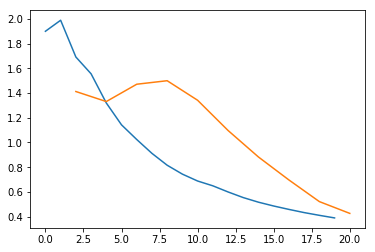

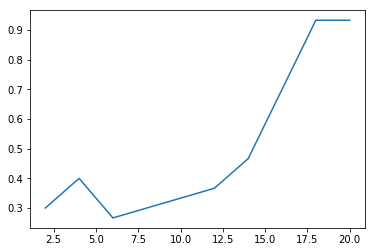

In [78]:
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

#### Unfreeze & train stage 2

In [79]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)
learn.load('stage1_GAFD')
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


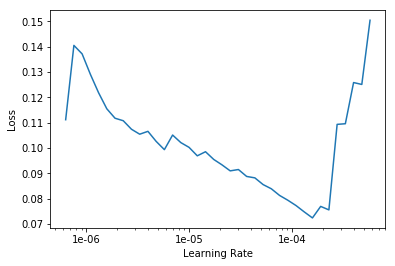

In [80]:
learn.lr_find()
learn.recorder.plot()

In [81]:
learn = create_cnn(data, models.resnet50, metrics=accuracy, 
                   callback_fns=[partial(SaveModelCallback, monitor='val_loss', 
                                         mode='auto', every='improvement', 
                                         name='bestmodel')])
learn.unfreeze()
learn.load('stage1_GAFD')
learn.fit_one_cycle(10, max_lr=slice(1e-6, 3e-5))

Total time: 00:32
epoch  train_loss  valid_loss  accuracy
1      0.096060    0.371468    0.933333  (00:02)
2      0.159481    0.337445    0.933333  (00:03)
3      0.123138    0.308410    0.933333  (00:03)
4      0.109796    0.287477    0.933333  (00:03)
5      0.096088    0.269403    0.933333  (00:03)
6      0.103573    0.271694    0.933333  (00:03)
7      0.093903    0.268027    0.933333  (00:02)
8      0.089593    0.266316    0.933333  (00:03)
9      0.082325    0.267644    0.933333  (00:03)
10     0.081103    0.277084    0.933333  (00:02)



In [82]:
learn.save('stage2_GAFD')

(None, None)

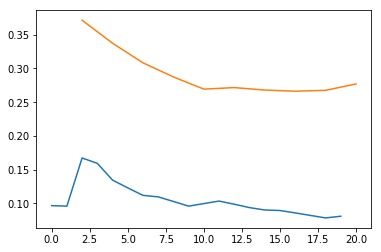

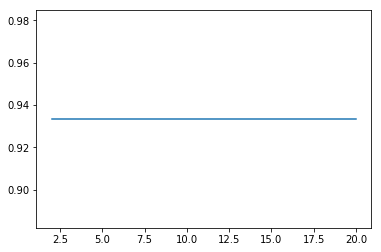

In [83]:
learn.load('stage2_GAFD')
learn.recorder.plot_losses() ,learn.recorder.plot_metrics()

### Interpretation

In [84]:
learn.load('stage2_GAFD')
interp = ClassificationInterpretation.from_learner(learn)

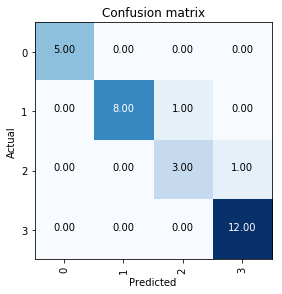

In [85]:
interp.plot_confusion_matrix()